In [2]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv("/Users/maximillian/Desktop/求职/Machine Learning/PyTorch/PYTORCH_NOTEBOOKS/Data/NYCTaxiFares.csv")
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [5]:
# 1: >$10; 0: else
df['fare_class'].value_counts()

0    80000
1    40000
Name: fare_class, dtype: int64

In [6]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

In [7]:
df['dist_km'] = haversine_distance(df,'pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude')

In [8]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321


In [10]:
# Transfer to datetime varialbe
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

In [11]:
df['EDTdate'] = df['pickup_datetime'] - pd.Timedelta(hours=4)     # Adjust Time Zone
df['Hour'] = df['EDTdate'].dt.hour
df['AMorPM'] = np.where(df['Hour']<12,'am','pm')     # Set AM and PM
df['Weekday'] = df['EDTdate'].dt.strftime("%a")     # Day of week
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPM,Weekday
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56+00:00,4,am,Mon
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53+00:00,11,am,Sat
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26+00:00,7,am,Sat
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03+00:00,17,pm,Sun
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01+00:00,22,pm,Fri


In [12]:
# Catergorical values
cat_cols = ['Hour','AMorPM','Weekday']
# Continuous values
cont_cols = ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','passenger_count','dist_km']

In [13]:
y_col = ['fare_class']

In [14]:
# Convert our three categorical columns to category dtypes.
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

In [15]:
df['AMorPM'].cat.categories

Index(['am', 'pm'], dtype='object')

In [16]:
df['AMorPM'].head().cat.codes

0    0
1    0
2    0
3    1
4    1
dtype: int8

In [17]:
df['Weekday'].cat.categories

Index(['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed'], dtype='object')

In [18]:
df['Weekday'].head().cat.codes

0    1
1    2
2    2
3    3
4    0
dtype: int8

In [20]:
hr = df['Hour'].cat.codes.values
ampm = df['AMorPM'].cat.codes.values
wkdy = df['Weekday'].cat.codes.values

cats = np.stack([hr, ampm, wkdy], 1)

cats[:5]

array([[ 4,  0,  1],
       [11,  0,  2],
       [ 7,  0,  2],
       [17,  1,  3],
       [22,  1,  0]], dtype=int8)

In [21]:
# Convert categorical variables to a tensor
cats = torch.tensor(cats, dtype=torch.int64)
cats[:5]

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        [17,  1,  3],
        [22,  1,  0]])

In [24]:
# Convert continuous variables to a tensor
conts = np.stack([df[col].values for col in cont_cols], 1)
conts = torch.tensor(conts, dtype=torch.float)
conts[:5]

tensor([[-73.9924,  40.7305, -73.9755,  40.7447,   1.0000,   2.1263],
        [-73.9901,  40.7406, -73.9742,  40.7441,   1.0000,   1.3923],
        [-73.9941,  40.7511, -73.9601,  40.7662,   2.0000,   3.3268],
        [-73.9905,  40.7564, -73.9712,  40.7482,   1.0000,   1.8641],
        [-73.9910,  40.7342, -73.9060,  40.7431,   1.0000,   7.2313]])

In [25]:
conts.type()

'torch.FloatTensor'

In [26]:
# Convert labels to a tensor
y = torch.tensor(df[y_col].values).flatten()

y[:5]

tensor([0, 0, 1, 0, 1])

In [27]:
cats.shape

torch.Size([120000, 3])

In [28]:
conts.shape

torch.Size([120000, 6])

In [29]:
y.shape

torch.Size([120000])

In [30]:
# This will set embedding sizes for Hours, AMvsPM and Weekdays
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(24, 12), (2, 1), (7, 4)]

In [59]:
class TabularModel(nn.Module):
    
    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
    
        for i in layers:
            layerlist.append(nn.Linear(n_in,i))
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
    
        self.layers = nn.Sequential(*layerlist)
        
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [60]:
torch.manual_seed(33)
model = TabularModel(emb_szs, conts.shape[1], 2, [200,100], p=0.4)   # out_sz = 2

In [61]:
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4)
    (8): Linear(in_features=100, out_features=2, bias=True)
  )
)

In [64]:
# Define loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [57]:
# Perform train/test splits
batch_size = 60000
test_size = 12000

cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [45]:
len(cat_train)

48000

In [46]:
len(cat_test)

12000

In [55]:
cat_train.shape

torch.Size([48000, 3])

In [65]:
# Train the model

import time
start_time = time.time()

epochs = 300
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(cat_train, con_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss)
    
    # a neat trick to save screen space:
    if i%25 == 1:
        print(f'epoch: {i:3} loss: {loss.item():10.8f}')
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
print(f'epoch: {i:3} loss: {loss.item():10.8f}')   #print the last time
print(f'\nDuration: {time.time() - start_time:.0f} seconds')    # print the time elapsed

epoch:   1 loss: 0.73476702
epoch:  26 loss: 0.28175953
epoch:  51 loss: 0.27130005
epoch:  76 loss: 0.26366547
epoch: 101 loss: 0.24847333
epoch: 126 loss: 0.23882693
epoch: 151 loss: 0.23384567
epoch: 176 loss: 0.23152705
epoch: 201 loss: 0.22901510
epoch: 226 loss: 0.22694363
epoch: 251 loss: 0.22558182
epoch: 276 loss: 0.22483119
epoch: 300 loss: 0.22434168

Duration: 221 seconds


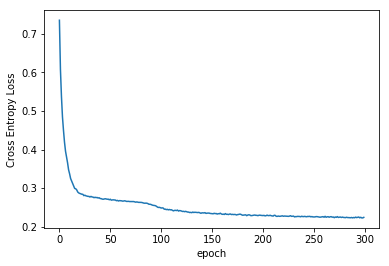

In [66]:
plt.plot(range(epochs), losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch');

In [67]:
# To evaluate the entire test set
with torch.no_grad():
    y_val = model(cat_test, con_test)
    loss = criterion(y_val, y_test)
print(f'CE Loss: {loss:.8f}')

CE Loss: 0.22938509


In [70]:
# First 50 predicted values
rows = 50
correct = 0
print(f'{"MODEL OUTPUT":26} ARGMAX  Y_TEST')
for i in range(rows):
    print(f'{str(y_val[i]):26} {y_val[i].argmax():^7}{y_test[i]:^7}')
    if y_val[i].argmax().item() == y_test[i]:
        correct += 1
print(f'\n{correct} out of {rows} = {100*correct/rows:.2f}% correct')

MODEL OUTPUT               ARGMAX  Y_TEST
tensor([ 1.4121, -2.1589])    0      0   
tensor([-1.0859,  1.5526])    1      0   
tensor([ 1.5169, -1.7122])    0      0   
tensor([-0.1252, -0.1131])    1      1   
tensor([ 1.6705, -2.1974])    0      0   
tensor([ 2.2595, -2.3326])    0      0   
tensor([ 2.1666, -1.9332])    0      0   
tensor([-2.6344,  2.3293])    1      1   
tensor([ 1.8026, -1.5521])    0      0   
tensor([-1.1202,  1.1749])    1      1   
tensor([ 1.6606, -1.9065])    0      0   
tensor([ 1.7513, -1.4005])    0      0   
tensor([ 1.6208, -2.1755])    0      0   
tensor([-1.9406,  2.4171])    1      1   
tensor([ 2.9076, -2.6939])    0      0   
tensor([-1.2627,  3.7672])    1      1   
tensor([ 0.0661, -0.2073])    0      1   
tensor([ 2.0373, -2.2544])    0      0   
tensor([ 0.9630, -1.2285])    0      0   
tensor([ 2.0076, -2.3123])    0      0   
tensor([-1.6103,  2.2893])    1      1   
tensor([-0.0702, -0.0010])    1      1   
tensor([-2.6648,  1.8373])    1   

In [ ]:
# Make sure to save the model only after the training has happened!
if len(losses) == epochs:
    torch.save(model.state_dict(), 'TaxiFareClassModel.pt')
else:
    print('Model has not been trained. Consider loading a trained model instead.')